# Making maps

![All the suburbs in Sydney](all_burbs.png)

We're going to get some shapefiles from data.gov.au, and then we're going to draw some maps

---

You'll need some prequisite libraries.

**NOTE: this mac method might well apply to you on a PC these days too. They've updated the libraries.**

If you're on a mac, it's easy, just do this:
```
pip3 install pandas shapely fiona descartes pyproj geopy
pip3 install geopandas
```

and on a pc, do this:
```
pip install pandas shapely fiona descartes pyproj geopy
pip install geopandas
```
You may have some already but pip will be cool with that.

If that works for you, ignore these next steps.

---

If you are on windows, and the steps above _didn't_ work out for you, geopandas is installed differently, so follow these 3 steps:

1. Install Visual CPPD Build Tools with the following link: https://visualstudio.microsoft.com/visual-cpp-build-tools/
2. Restart your computer
3. Open Visual Studio Code again after the restart and copy and paste the following commands into your terminal:

    ```
    pip install wheel pipwin numpy pandas shapely pyproj six rtree
    pipwin install gdal fiona
    pip install descartes geopandas geopy
    ```

Copy that whole lot into your terminal, press enter, and it'll sort it out.

--- 

We're going to get a shapefile of suburb boundaries from here:

https://data.gov.au/dataset/ds-dga-91e70237-d9d1-4719-a82f-e71b811154c6/details

In [58]:
import os
import geopandas as gp
import shapely
# import fiona # you might need this, but probably not.
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopy.distance


shp_file_name = r"GDA2020\nsw_localities.shp" # r is for a raw string, you don't need it if you use forward slashes
zip_file_name = r"gda2020.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    # You will have to go and find this link, it changes every year
)


In [59]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

To get a load of shape files from data.gov.au, more specifically, [here](https://data.gov.au/dataset/nsw-suburb-locality-boundaries-psma-administrative-boundaries/resource/bf8b5180-fcea-44bd-bd76-af14cc4b0fe0)

In [60]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [61]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name), 
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


#### Shapefiles are the format that a lot of GIS tools use.

#### GIS means Geographic Information System

pronounced: _gee eye ess_

not pronounced: _jizz_

In [62]:
burbs = gp.read_file(shp_file_name)       
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
# https://epsg.io/8021
# GDA2020 is the latest and least wrong coord set for Sydney
burbs.sample(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
3024,lcpdKPDAXylhK8H,loc7a9ab6a24e15,2022-12-14,Newrybar,Gazetted Locality,NSW,"POLYGON ((153.548 -28.705, 153.55 -28.705, 153..."
2421,lcpbe23138cec1a,loc72b664999d25,2021-12-13,Liverpool,Gazetted Locality,NSW,"POLYGON ((150.918 -33.905, 150.918 -33.907, 15..."


There are a bunch of junk columns in there. Normally I'd leave them in, but because we're going to be looking are this data in dataframes, I'll take them out so that it's easier on the eyes.

In [63]:
cols_to_drop = ["LOC_PID", "LC_PLY_PID", "DT_CREATE	"]
burbs.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
burbs.head(2)

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,2021-06-24,Aarons Pass,Gazetted Locality,NSW,"POLYGON ((149.795 -32.823, 149.794 -32.828, 14..."
1,2022-09-28,Abbotsbury,Gazetted Locality,NSW,"POLYGON ((150.873 -33.86, 150.873 -33.861, 150..."


Only uncomment this if you've got a fast computer and a lot of time!

It makes the map at the top of this file.

In [64]:
#burbs.geometry.plot()

Let's pull out a single row, a single suburb, and look at it.

DT_CREATE                                  2021-06-24 00:00:00
LOC_NAME                                           Aarons Pass
LOC_CLASS                                    Gazetted Locality
STATE                                                      NSW
geometry     POLYGON ((149.79499744848894 -32.8227401143710...
Name: 0, dtype: object


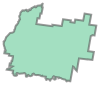

In [65]:
a = burbs.iloc[0]
print(a)
a.geometry

You can simplify the boundaries a bit. This is useful if you want to speed up some of the inclusion (`within`) testing on a _very_ large dataset.

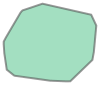

In [66]:
a.geometry.convex_hull

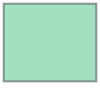

In [67]:
a.geometry.envelope

When we plot a geopandas polygon\* it actually draws it, rather than showing the textual information, which is nice.

\* it's acutally a Shapely polygon I think.

---

If we want to measure some distances, we need _points_. The distance between two shapes is ambiguous.

The easiest way to do this is to get the centroid of the polygon.

In [68]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

burbs.sample(2)

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid
3707,2021-06-24,St Albans,Gazetted Locality,NSW,"POLYGON ((151.014 -33.197, 151.014 -33.199, 15...",POINT (151.00751 -33.25177)
1975,2023-06-26,Holsworthy,Gazetted Locality,NSW,"POLYGON ((150.948 -33.947, 150.95 -33.949, 150...",POINT (150.91365 -34.06839)


And we can plot this nicely as a map. Note that this is different to doing a `scatter` of lat and long because it's aware that they're spatially related; no squishing.

<Axes: >

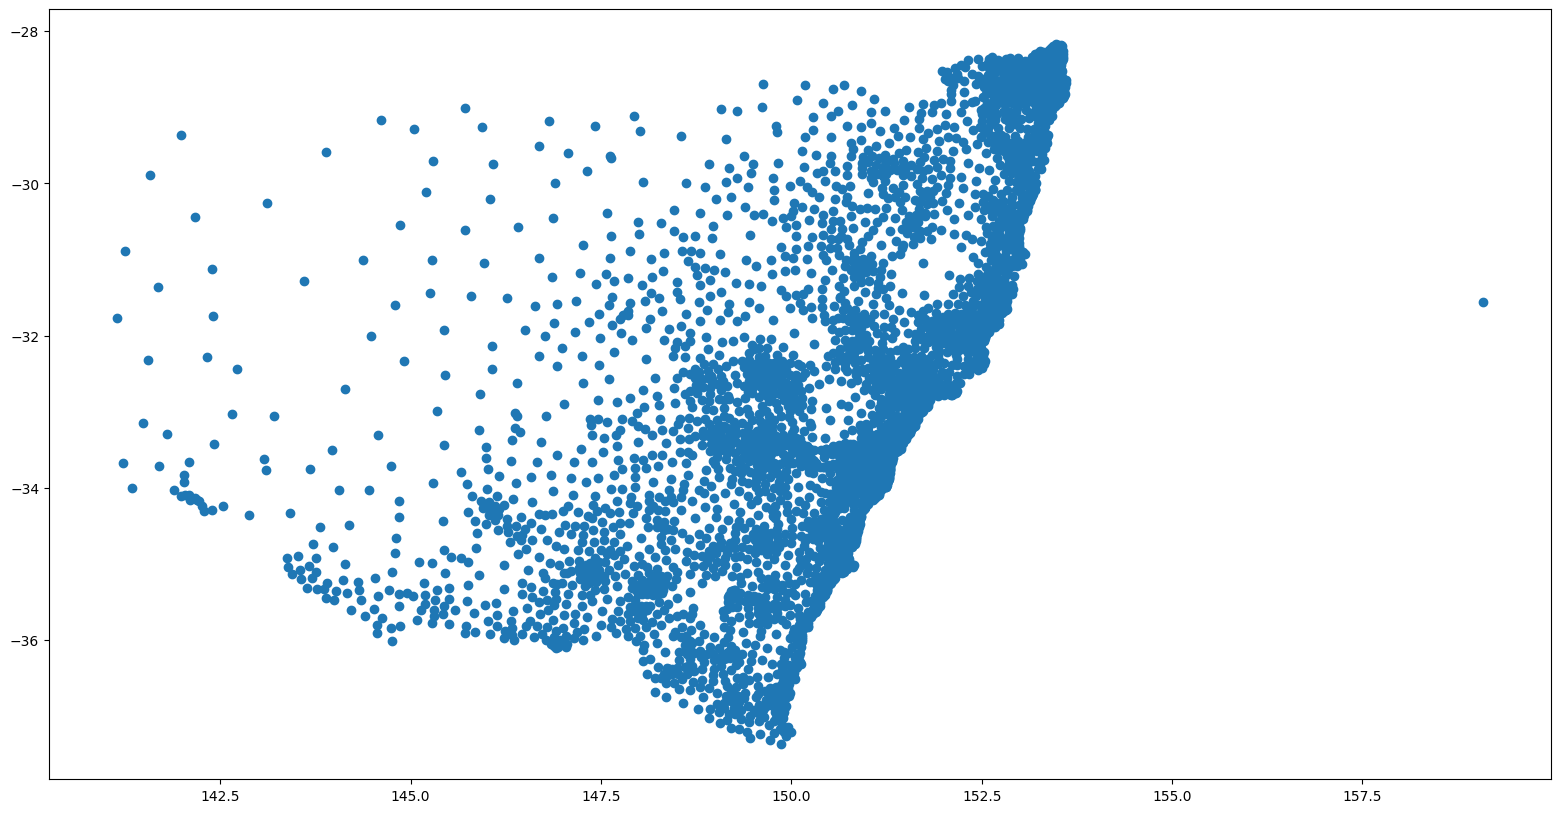

In [69]:
burbs.centroid.plot()

POINT (149.8029161109966 -32.87909863381044)


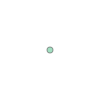

In [70]:
a = burbs.iloc[0]
print(a.centroid)
a.centroid

Let's make a new point that's on the UNSW campus. We need to use shapely to do this.

Then calculate the distance from that point to the centroid of each suburb.

In [71]:
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
burbs["distance_from_UNSW"] = burbs.centroid.distance(right_here)

In [72]:
burbs.head(2)

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid,distance_from_UNSW
0,2021-06-24,Aarons Pass,Gazetted Locality,NSW,"POLYGON ((149.795 -32.823, 149.794 -32.828, 14...",POINT (149.80292 -32.8791),1.765092
1,2022-09-28,Abbotsbury,Gazetted Locality,NSW,"POLYGON ((150.873 -33.86, 150.873 -33.861, 150...",POINT (150.86117 -33.87008),0.371882


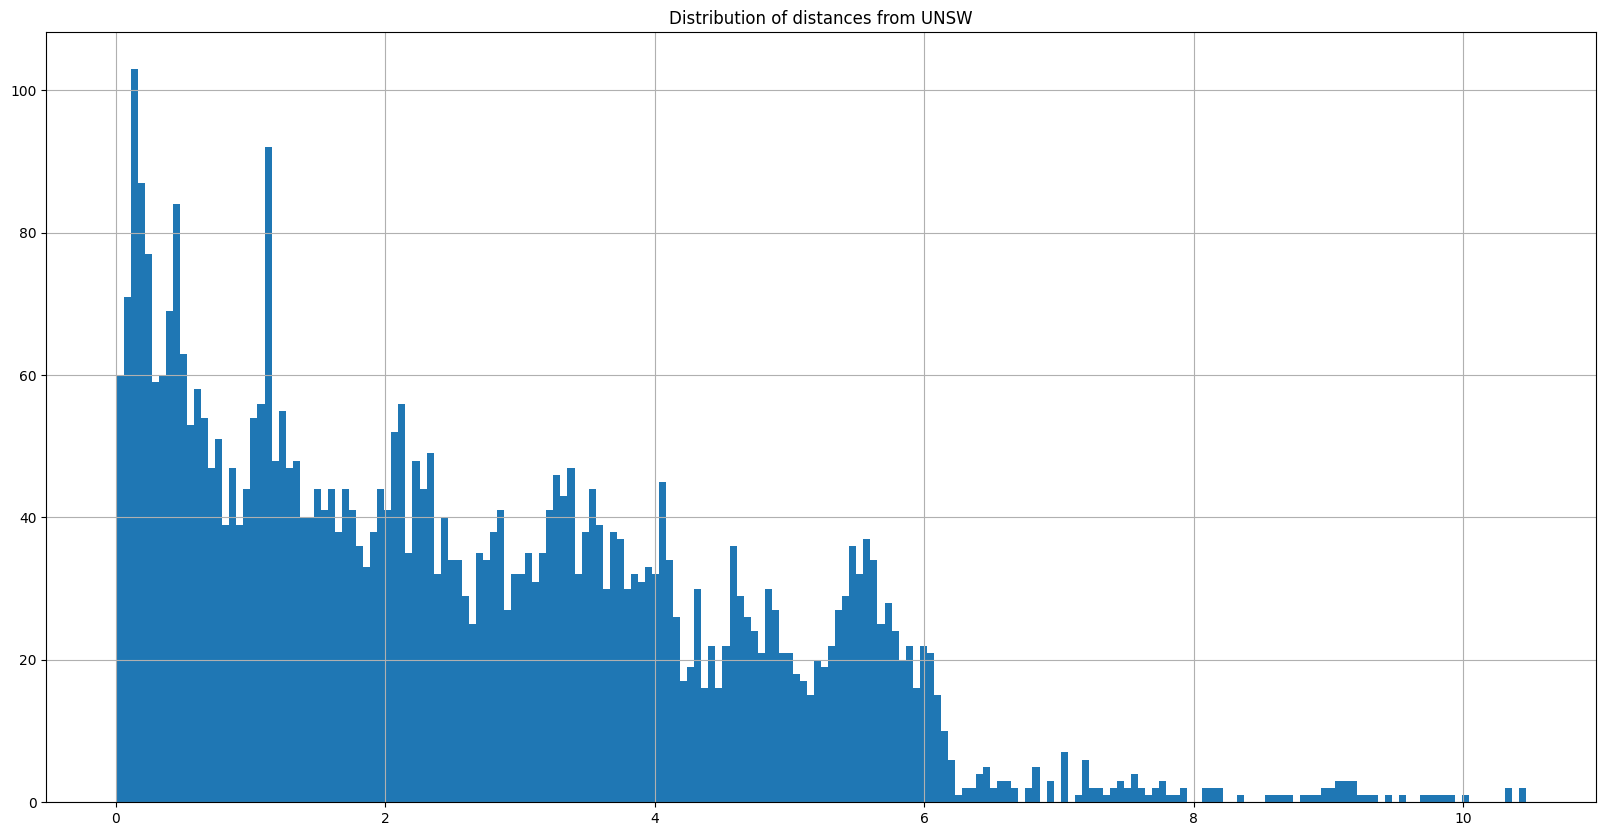

In [73]:
burbs.distance_from_UNSW.hist(bins=200)
plt.title("Distribution of distances from UNSW");

This gives distance in whole numbers of lat long, which is a weird number.

If we want to get it in metres, we can be a bit more involved:

In [84]:
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
burbs["distance_from_UNSW_m"] = burbs.centroid.apply(lambda c: geopy.distance.distance((c.y, c.x), (right_here.y, right_here.x)).m)
burbs["distance_from_UNSW_km"] = burbs.centroid.apply(lambda c: geopy.distance.distance((c.y, c.x), (right_here.y, right_here.x)).km)
burbs.head(2)

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid,distance_from_UNSW,distance_from_UNSW_m,distance_from_UNSW_km
0,2021-06-24,Aarons Pass,Gazetted Locality,NSW,"POLYGON ((149.795 -32.823, 149.794 -32.828, 14...",POINT (149.80292 -32.8791),1.765092,175777.732599,175.777733
1,2022-09-28,Abbotsbury,Gazetted Locality,NSW,"POLYGON ((150.873 -33.86, 150.873 -33.861, 150...",POINT (150.86117 -33.87008),0.371882,34523.069364,34.523069


Apply is a really fast and useful tool!

Let's get rid of everything above 5km and see what we can plot:

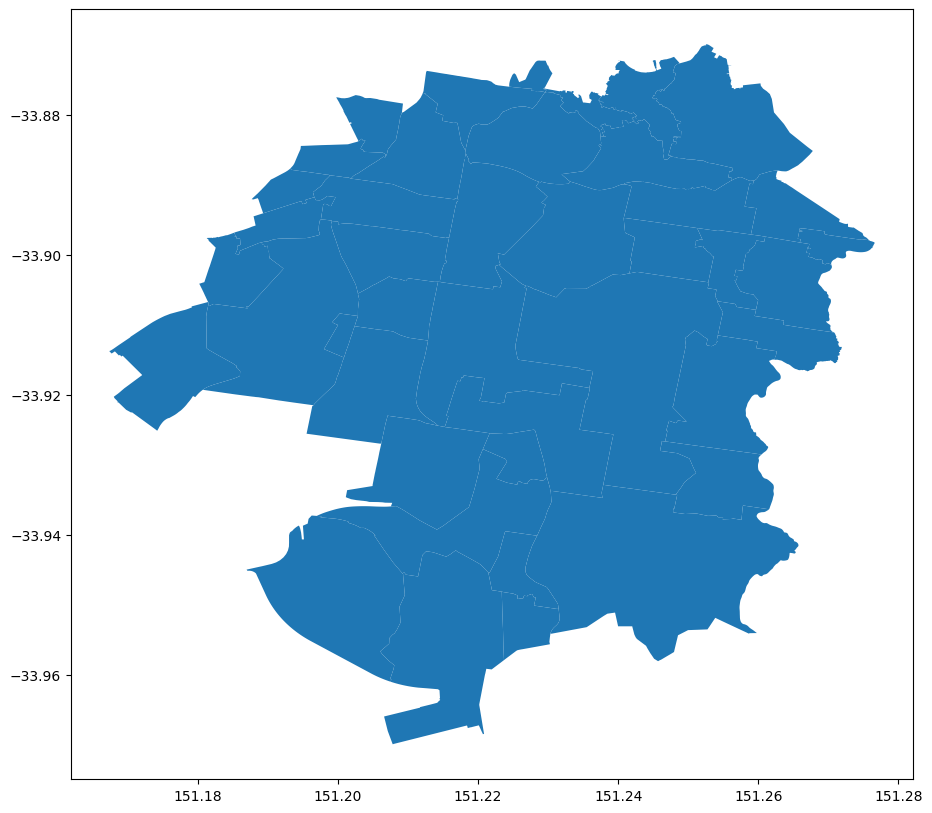

In [88]:
close_burbs = burbs[burbs.distance_from_UNSW_km < 5]
close_burbs.plot();

We can simplify shapes in a few ways:

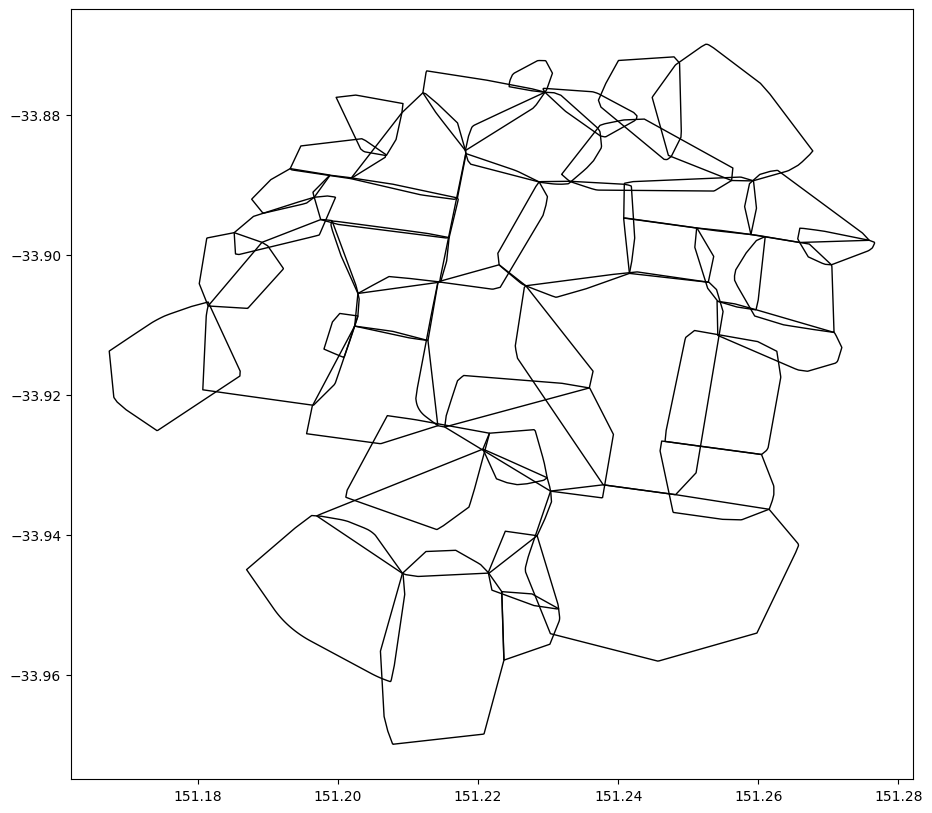

In [89]:
close_burbs.geometry.convex_hull.plot(edgecolor="black", facecolor="none");

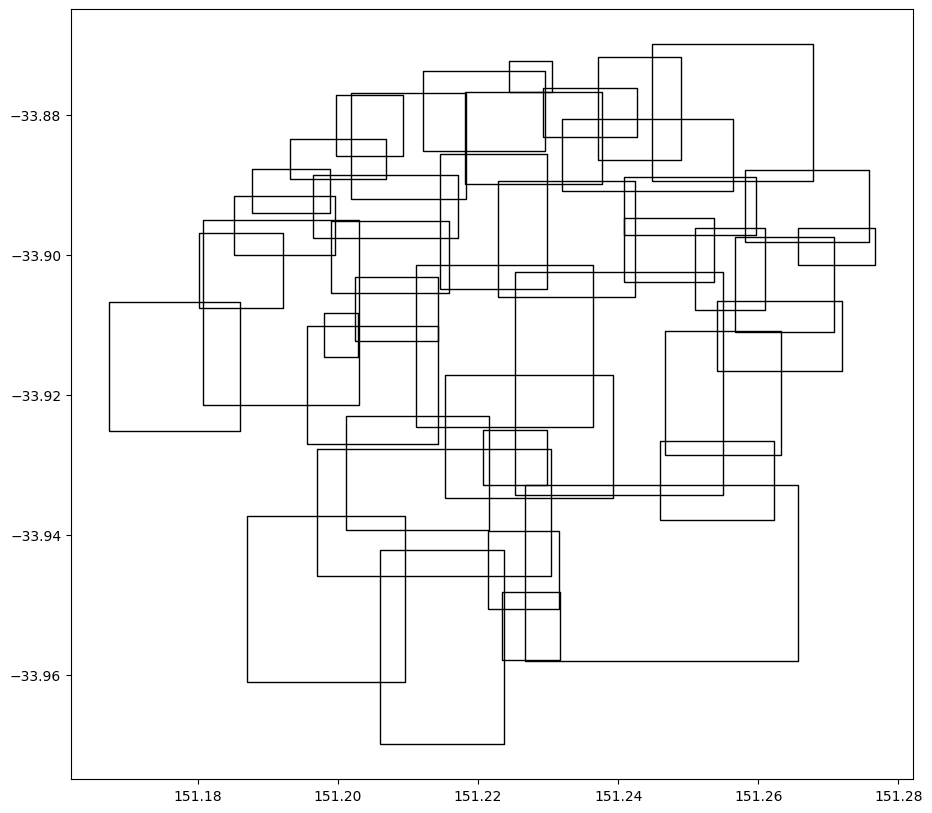

In [90]:
close_burbs.geometry.envelope.plot(edgecolor="black", facecolor="none");

![](http://www.personal.kent.edu/~rmuhamma/Compgeometry/MyCG/Gifs-CompGeometry/ch2.gif)

Convex hulls are a useful aproximation if you want to do fast calculations.

You can use this to speed up calculations sometimes. It goes radius, bounding box, convex hull, complex polygon. I.e. if the points are not within radius_1 + radius_2 of each other, there's no point doing any other checks.

Often it's faster to do all of these checks in order, flowing from one to the next, than it is to just go straight to the most complex. But that depends on how much effort you can be bothered to put in.

What about putting labels on the map?

In [91]:
really_close_burbs.head(2)

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid,distance_from_UNSW,distance_from_UNSW_m
903,2022-12-14,Centennial Park,Gazetted Locality,NSW,"POLYGON ((151.234 -33.89, 151.235 -33.89, 151....",POINT (151.23361 -33.89787),0.020336,2244.695759
1050,2021-06-24,Coogee,Gazetted Locality,NSW,"POLYGON ((151.253 -33.913, 151.253 -33.913, 15...",POINT (151.25464 -33.91976),0.024740,2290.656828


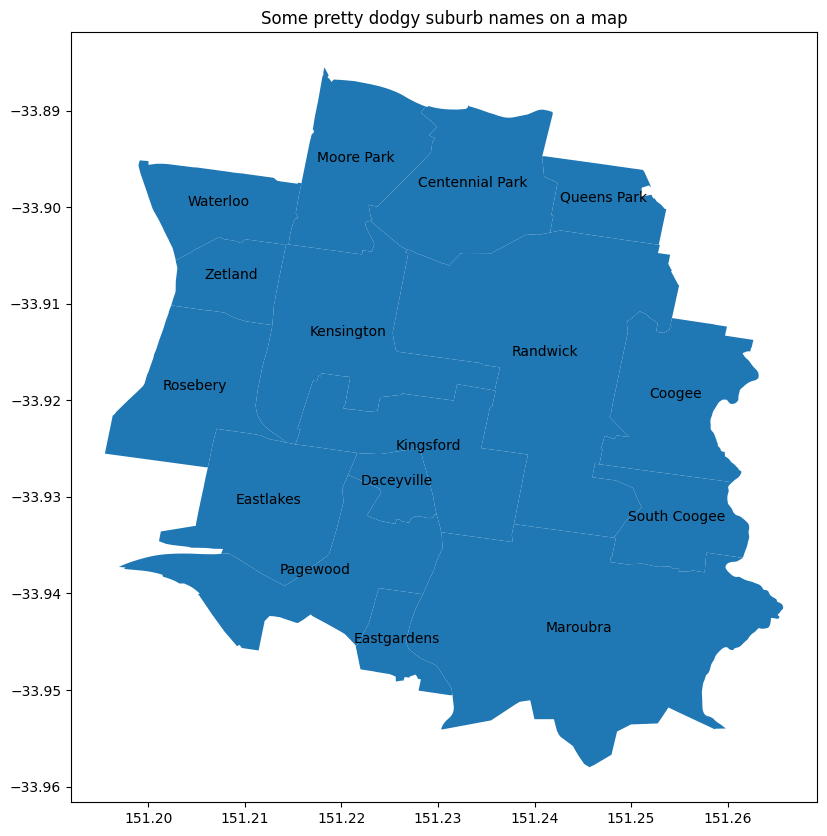

In [93]:
really_close_burbs = burbs[burbs.distance_from_UNSW < 0.03]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
    # Some debugging statements to help you understand what's going on
    # print(idx, row)
    # print("annotation", row.LOC_NAME)
    # print(
    #     "coords", row.centroid.coords,
    #     "tuple", tuple(row.centroid.coords),
    #     "zero", tuple(row.centroid.coords)[0],
    # )
    plt.annotate(
        text=row.LOC_NAME,
        xy=tuple(row.centroid.coords)[0],
        xycoords="data",
        horizontalalignment="center",
    )
plt.title("Some pretty dodgy suburb names on a map");

# Inclusion Testing

We often want to be able to tell if a point is in a suburb or not. We'd do that with a polygon inclusion test.

![](http://www.geeksforgeeks.org/wp-content/uploads/polygon31.png)

[How to check if a given point lies inside or outside a polygon?](http://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/)

Luckily we've got one built in!

In [80]:
print(right_here)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if right_here.within(row.geometry):
        in_this_burb = row
        
in_this_burb

POINT (151.2299732 -33.9178754)


DT_CREATE                                             2023-06-26 00:00:00
LOC_NAME                                                       Kensington
LOC_CLASS                                               Gazetted Locality
STATE                                                                 NSW
geometry                POLYGON ((151.22674162751696 -33.9044996267385...
centroid                    POINT (151.22064615674822 -33.91335562335306)
distance_from_UNSW                                               0.010364
distance_from_UNSW_m                                           997.644164
Name: 2155, dtype: object

This might actually be a case where a `lambda` is a good idea:

In [81]:
in_this_burb = really_close_burbs[really_close_burbs.geometry.apply(lambda x: right_here.within(x))]
in_this_burb

,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid,distance_from_UNSW,distance_from_UNSW_m
2155,2023-06-26,Kensington,Gazetted Locality,NSW,"POLYGON ((151.227 -33.904, 151.227 -33.905, 15...",POINT (151.22065 -33.91336),0.010364,997.644164


Both of these examples are testing when you know it's only in _one_ polygon. If you want to test for multiple you'd need a more complex loop.

This is useful if you need to get the suburb name of some points. You'd check each point to see if it's in each suburb, and if it is, you've got it. Careful though, that's a O(n²) job.

How about colouring suburbs according to some kind of scalar value?

[That's called a _chloropleth_](http://geopandas.readthedocs.io/en/latest/mapping.html?highlight=color#chloropleth-maps)

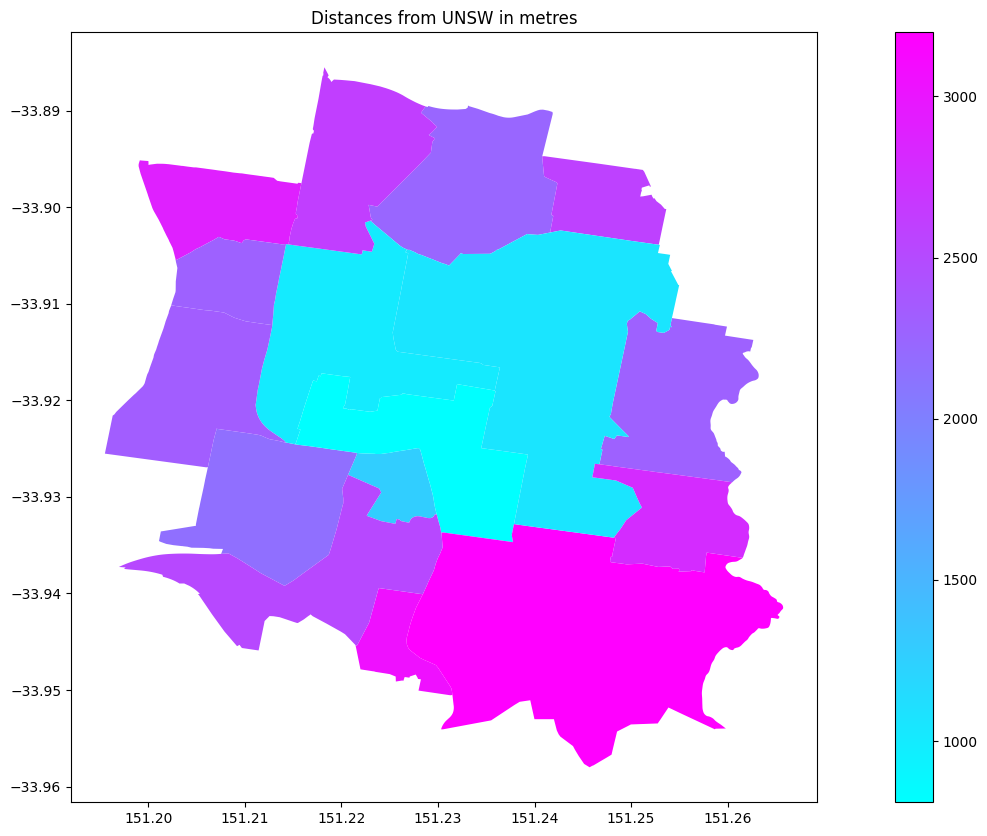

In [95]:
really_close_burbs.plot(column='distance_from_UNSW_m', cmap='cool', legend=True)
plt.title("Distances from UNSW in metres");

I don't think that could be any easier!

You can see the list of [colour scale options here](http://matplotlib.org/users/colormaps.html)

What if you want to put some points onto the map? In this case we'll plot the centroids, but you can plot any points because they are using geographic coordinates.

<Axes: >

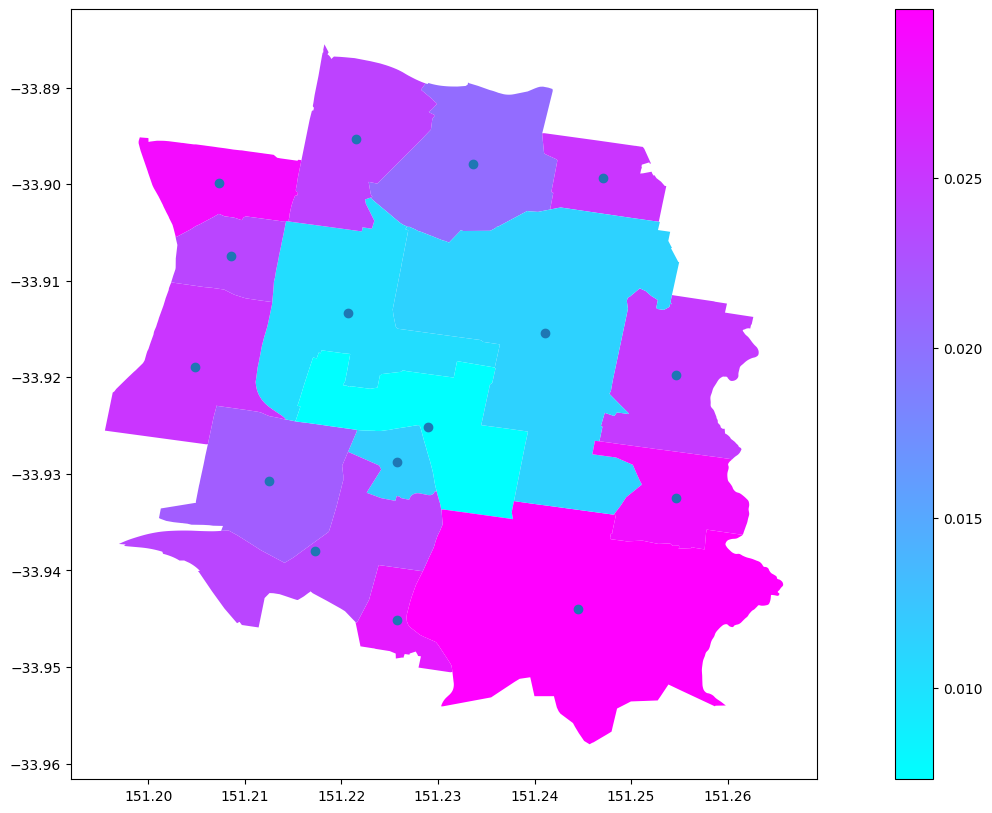

In [83]:
ax = really_close_burbs.plot(column='distance_from_UNSW', cmap='cool', legend=True)
really_close_burbs.centroid.plot(ax=ax)

## Handy links

* [Geopandas docs](http://geopandas.readthedocs.io)
* [Geopandas on GitHib](https://github.com/geopandas/geopandas)
* [Another map making tutorial](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html)
* [MatPlotLib colour scale options](http://matplotlib.org/users/colormaps.html)

I'd love to hear if you come across any other useful things!